In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from pathlib import Path
from sklearn import metrics
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision

from datetime import datetime
from collections import OrderedDict

In [2]:
import pickle

In [3]:
PATH = Path("/data2/yinterian/multi-task-romain")

In [4]:
gap = "5min"
gap

'5min'

In [5]:
filename = "data_train_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    train = pickle.load(f)

In [6]:
filename = "data_valid_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    valid = pickle.load(f)

In [7]:
train.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
0,10013,10013_18,1,87,49,7,2,1,0,1,95.44,55.88,"[[110.1, 0.0, 85.7, 37.1, 55.4], [110.9, 0.0, ...",0
1,10013,10013_19,1,87,49,7,2,1,0,1,107.4,68.4,"[[96.0, 92.0, 106.2, 35.2, 55.9], [101.9, 92.7...",0
2,10013,10013_20,1,87,49,7,2,1,0,1,102.08,68.28,"[[106.2, 94.5, 127.6, 43.6, 69.7], [106.1, 94....",0
3,10013,10013_23,1,87,49,7,2,1,0,1,99.14,86.14,"[[93.0, 93.4, 139.6, 51.0, 80.9], [93.0, 93.8,...",0
4,10013,10013_24,1,87,49,7,2,1,0,1,108.1,69.96,"[[97.5, 94.0, 144.1, 54.4, 86.4], [101.3, 94.5...",0


In [8]:
valid.head()

,subject_id,key,gender,age,sapsii,sofa,care_unit,amine,sedation,ventilation,prediction_mean_HR,prediction_mean_MAP,series,group
1400,11018,11018_103,0,67,47,1,0,0,0,0,57.0333,127.633,"[[58.0, 100.0, 141.0, 122.0, 130.0], [61.0, 10...",1
1401,11018,11018_29,0,67,47,1,0,0,0,0,74.94,71.07,"[[78.0, 97.0, 99.0, 59.0, 72.0], [78.0, 97.0, ...",1
1402,11018,11018_30,0,67,47,1,0,0,0,0,75.24,74.6167,"[[74.0, 97.0, 99.0, 59.0, 72.0], [75.0, 96.0, ...",1
1403,11018,11018_32,0,67,47,1,0,0,0,0,82.29,79.1533,"[[78.0, 96.0, 108.0, 64.0, 78.0], [77.0, 97.0,...",1
1404,11018,11018_33,0,67,47,1,0,0,0,0,80.54,82.64,"[[83.0, 93.0, 113.0, 66.0, 81.0], [82.0, 93.0,...",1


In [13]:
train.shape, valid.shape

((59742, 14), (7086, 14))

In [14]:
subject_id_list = np.sort(np.unique(train.subject_id.values))
id2index = {v: k+1 for k,v in enumerate(subject_id_list)}
num_subjects = len(subject_id_list)

In [15]:
num_subjects

2295

## Dataset

In [8]:
def get_mean_std_series(train):
    ss = np.concatenate(train.series.values)
    ss = ss.reshape(-1,5)
    return ss.mean(axis=0), ss.std(axis=0)

In [9]:
def get_mean_std_static(train):
    res = {}
    for name in ["age", "sapsii", "sofa"]:
        values = train[name].values
        res[name] = (values.mean(), values.std())
    res["series"] = get_mean_std_series(train)
    return res

In [10]:
norm_dict = get_mean_std_static(train)
norm_dict 

{'age': (64, 15.073998327645949),
 'sapsii': (33, 14.215114554630107),
 'sofa': (4, 3.7687923741651197),
 'series': (array([ 83.25271123,  93.7286662 , 120.81020051,  58.76277023,
          78.52866913]),
  array([16.10279665, 17.32261077, 21.2893833 , 12.28384779, 14.32805636]))}

In [16]:
class MultiTask(Dataset):
    def __init__(self, df, norm_dict, id2index, k=20, train=True):
        """
        Args:
            df: dataframe with data
            norm_dict: mean and std of all variables to normalize
            
        """
        self.norm_dict = norm_dict
        self.df = df
        self.names = ["age", "sapsii", "sofa"] ## needs normalization
        self.names_binary = ["gender", "amine", "sedation", "ventilation"]
        self.id2index = id2index
        self.train = train
        self.df_sample = self.pick_a_sample(k)
            
    def pick_a_sample(self, k=20):
        """ Picks sample with the same number of observations per patient"""
        if not self.train: # fix seed for validation and test
            np.random.seed(3)
        sample = self.df.groupby("subject_id", group_keys=False).apply(lambda x: x.sample(k, replace=True))
        sample = sample.copy()
        if self.train:
            self.subject_index = [self.id2index[subject_id] for subject_id in sample.subject_id.values]
            self.random = np.random.choice(2, sample.shape[0], p=[0.1, 0.9])
            self.subject_index = self.subject_index*self.random
        return sample

    def __getitem__(self, index):
        row = self.df_sample.iloc[index,:]
        x_series = (row.series - self.norm_dict["series"][0])/self.norm_dict["series"][1]
        x_cont = [(row[name]-self.norm_dict[name][0])/self.norm_dict[name][1] for name in self.names]
        x_binary = [row[name] for name in self.names_binary]
        subject_index = 0
        if self.train:
            subject_index = self.subject_index[index]
        x_cat = np.array([row["care_unit"], subject_index])
        x_cont = np.array(x_cont + x_binary)
        return x_series, x_cont, x_cat, row["prediction_mean_HR"], row["prediction_mean_MAP"]

    def __len__(self):
        return self.df_sample.shape[0]

In [17]:
train_ds = MultiTask(train, norm_dict, id2index)
valid_ds = MultiTask(valid, norm_dict, id2index, train=False)

In [18]:
2295*20

45900

In [19]:
len(train_ds)

45900

## Model

In [20]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [21]:
class EventModel1(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel1, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 10 + 1 + 5
        self.linear1 = nn.Linear(7, 10)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(10)

    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x_cont = self.bn1(F.relu(self.linear1(x_cont))) 
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        return self.out1(x), self.out2(x)

In [23]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat1 = []
    ys1 = []
    y_hat2 = []
    ys2 = []
    for x_series, x_cont, x_cat, y1, y2 in valid_dl:
        batch = y1.shape[0]
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
        mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
        mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
        loss = mse_loss1 + mse_loss2
        sum_loss += batch*(loss.item())
        total += batch
        y_hat1.append(out1.view(-1).detach().cpu().numpy())
        ys1.append(y1.view(-1).cpu().numpy())
        y_hat2.append(out2.view(-1).detach().cpu().numpy())
        ys2.append(y2.view(-1).cpu().numpy())
    
    y_hat1 = np.concatenate(y_hat1)
    y_hat2 = np.concatenate(y_hat2)
    ys1 = np.concatenate(ys1)
    ys2 = np.concatenate(ys2)
    r2_1 = metrics.r2_score(ys1, y_hat1)
    r2_2 = metrics.r2_score(ys2, y_hat2)
    return sum_loss/total, r2_1, r2_2

In [24]:
def train_epochs(model, train_ds, optimizer, filename, lr=1e-3, epochs = 30):
    prev_val_r2 = 0
    for i in range(epochs):
        sum_loss1 = 0
        sum_loss2 = 0
        total = 0
        train_ds.pick_a_sample()
        train_dl = DataLoader(train_ds, batch_size=5000, shuffle=True)
        for x_series, x_cont, x_cat, y1, y2 in train_dl:
            model.train()
            x_series = x_series.float().cuda()
            x_cont = x_cont.float().cuda()
            x_cat = x_cat.long().cuda()
            y1 = y1.float().cuda()
            y2 = y2.float().cuda()
            out1, out2 = model(x_series, x_cont, x_cat)
            mse_loss1 = F.mse_loss(out1, y1.unsqueeze(-1))
            mse_loss2 = F.mse_loss(out2, y2.unsqueeze(-1))
            loss = mse_loss1 + mse_loss2
            sum_loss1 += len(y1) * mse_loss1.item()
            sum_loss2 += len(y1) * mse_loss2.item()
            total += len(y1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 1 == 0:
            val_loss, val_r2_1, val_r2_2 = val_metrics(model, valid_dl)
            print("\tTrain loss: {:.3f} {:.3f} valid loss: {:.3f} valid r2 hr {:.3f} valid r2 map {:.3f}".format(
                sum_loss1/total, sum_loss2/total, val_loss, val_r2_1, val_r2_2))
            
        if val_r2_1 > prev_val_r2:
            prev_val_r2 = val_r2_1
            if val_r2_1 > 0.7:
                path = "{0}/models/{1}_r2_{2:.0f}_{3:.0f}.pth".format(PATH, filename, 100*val_r2_1, 100*val_r2_2) 
                save_model(model, path)
                print(path)

In [25]:
batch_size = 5000
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [26]:
model = EventModel1().cuda()

In [27]:
val_metrics(model, valid_dl)

(13544.176280545113, -27.85965181518579, -33.43668429774548)

In [28]:
# 0s in training
model = EventModel1().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model1_patient", epochs=15)

	Train loss: 5141.782 4473.121 valid loss: 3934.155 valid r2 hr -8.019 valid r2 map -8.099
	Train loss: 993.991 724.067 valid loss: 367.793 valid r2 hr 0.277 valid r2 map -0.021
	Train loss: 287.551 275.328 valid loss: 528.999 valid r2 hr -0.107 valid r2 map -0.373
	Train loss: 148.575 105.352 valid loss: 119.644 valid r2 hr 0.731 valid r2 map 0.716
/data2/yinterian/multi-task-romain/models/model1_patient_r2_73_72.pth
	Train loss: 66.569 67.318 valid loss: 115.536 valid r2 hr 0.760 valid r2 map 0.698
/data2/yinterian/multi-task-romain/models/model1_patient_r2_76_70.pth
	Train loss: 46.777 50.644 valid loss: 97.147 valid r2 hr 0.810 valid r2 map 0.729
/data2/yinterian/multi-task-romain/models/model1_patient_r2_81_73.pth
	Train loss: 37.498 44.489 valid loss: 93.477 valid r2 hr 0.814 valid r2 map 0.744
/data2/yinterian/multi-task-romain/models/model1_patient_r2_81_74.pth
	Train loss: 32.796 39.040 valid loss: 78.540 valid r2 hr 0.844 valid r2 map 0.784
/data2/yinterian/multi-task-romain/

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer,filename="model1", epochs=20)

	Train loss: 20.143 23.333 valid loss: 46.038 valid r2 hr 0.904 valid r2 map 0.880
/data2/yinterian/multi-task-romain/models/model1_r2_90_88.pth
	Train loss: 15.852 18.513 valid loss: 41.665 valid r2 hr 0.914 valid r2 map 0.890
/data2/yinterian/multi-task-romain/models/model1_r2_91_89.pth
	Train loss: 14.218 16.658 valid loss: 35.343 valid r2 hr 0.927 valid r2 map 0.907
/data2/yinterian/multi-task-romain/models/model1_r2_93_91.pth
	Train loss: 12.939 15.162 valid loss: 30.981 valid r2 hr 0.938 valid r2 map 0.916
/data2/yinterian/multi-task-romain/models/model1_r2_94_92.pth
	Train loss: 11.947 14.292 valid loss: 27.729 valid r2 hr 0.945 valid r2 map 0.923
/data2/yinterian/multi-task-romain/models/model1_r2_95_92.pth
	Train loss: 11.275 13.534 valid loss: 25.375 valid r2 hr 0.950 valid r2 map 0.930
/data2/yinterian/multi-task-romain/models/model1_r2_95_93.pth
	Train loss: 10.621 13.143 valid loss: 24.336 valid r2 hr 0.952 valid r2 map 0.933
/data2/yinterian/multi-task-romain/models/model

### Model 2

In [ ]:
class EventModel2(nn.Module):
    def __init__(self, hidden_size=100):
        super(EventModel2, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num = hidden_size + 1 + 5 + 7
        self.linear1 = nn.Linear(self.num, self.num)
        self.out1 = nn.Linear(self.num, 1)
        self.out2 = nn.Linear(self.num, 1)
        self.bn1 = nn.BatchNorm1d(self.num)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        return self.out1(x), self.out2(x)

In [ ]:
model = EventModel2().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model2", epochs=15)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model2", epochs=20)

In [ ]:
train_epochs(model, train_ds, optimizer, filename="model2", epochs=10)

## Model 3

In [ ]:
class EventModel3(nn.Module):
    def __init__(self, hidden_size=100, num2=50):
        super(EventModel3, self).__init__()
        self.embedding1 = nn.Embedding(5, 1)
        self.embedding2 = nn.Embedding(num_subjects+1, 5)
        self.gru = nn.GRU(5, hidden_size, batch_first=True)
        self.num1 = hidden_size + 1 + 5 + 7
        self.num2 = num2
        self.linear1 = nn.Linear(self.num1, self.num2)
        self.linear2 = nn.Linear(self.num2, self.num2)
        self.out1 = nn.Linear(self.num2, 1)
        self.out2 = nn.Linear(self.num2, 1)
        self.bn1 = nn.BatchNorm1d(self.num2)
        self.bn2 = nn.BatchNorm1d(self.num2)
        
    def forward(self, x_series, x_cont, x_cat):
        _, ht = self.gru(x_series)
        x_cat_1 = self.embedding1(x_cat[:,0])
        x_cat_2 = self.embedding2(x_cat[:,1])
        x = torch.cat((ht[-1], x_cat_1, x_cat_2, x_cont), 1)
        x = self.bn1(F.relu(self.linear1(x)))
        x = self.bn2(F.relu(self.linear2(x)))
        return self.out1(x), self.out2(x)

In [ ]:
model = EventModel3().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model3", epochs=15)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-5)
train_epochs(model, train_ds, optimizer, filename="model3", epochs=15)

## Calibration plot

In [35]:
path = PATH/"models/model3_r2_97_94.pth"
model = EventModel3().cuda()
load_model(model, path)

In [36]:
filename = "data_test_{gap}.pickle".format(gap=gap)
with open(PATH/filename, 'rb') as f:
    test = pickle.load(f)
print(filename)

data_test_5min.pickle


In [39]:
test_ds = MultiTask(test, norm_dict, id2index, k=25, train=False)
test.shape, len(test_ds)

((8233, 14), 4561)

In [41]:
test_dl = DataLoader(test_ds, batch_size=4561)

In [42]:
val_metrics(model, test_dl)

(20.041011810302734, 0.9709641479574554, 0.9397464836156326)

In [43]:
def predict_one_batch(model, dl):
    for x_series, x_cont, x_cat, y1, y2 in dl:
        x_series = x_series.float().cuda()
        x_cont = x_cont.float().cuda()
        x_cat = x_cat.long().cuda()
        y1 = y1.float().cuda()
        y2 = y2.float().cuda()
        out1, out2 = model(x_series, x_cont, x_cat)
    return out1.detach().cpu().numpy(), out2.detach().cpu().numpy(), y1.detach().cpu().numpy(), y2.detach().cpu().numpy()

In [44]:
out1, out2, y1, y2 = predict_one_batch(model, test_dl)

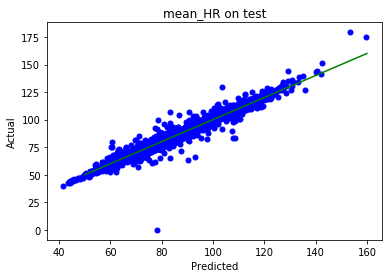

In [49]:
x = np.linspace(50, 160, 1000)
plt.plot(out1, y1, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_HR on test")
plt.plot(x, x, '-g')
plt.show()

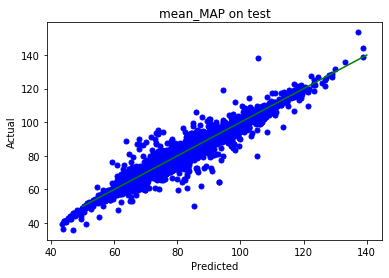

In [48]:
x = np.linspace(50, 140, 1000)
plt.plot(out2, y2, 'bo', ms=5)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("mean_MAP on test")
plt.plot(x, x, '-g')
plt.show()